#A-NET - Siamese Network

```
Implemented By Muhammad Hanan Asghar
```

#Libraries

In [ ]:
!pip install -r requirements.txt

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
!rm -rf /content/data
!rm -rf /content/negative

In [ ]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')

if not os.path.exists(POS_PATH):
  os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
  os.makedirs(NEG_PATH)

#Dataset Collection and Preprocessing

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-03-02 15:55:08--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  15.6MB/s    in 12s     

2022-03-02 15:55:21 (13.9 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

Extracting Faces from Negative Images

In [ ]:
import dlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import uuid

# Detector Model(Face)
detector = dlib.get_frontal_face_detector()

In [ ]:
def gen_faces(image):
    """
    Function that gets image as input and generate face from it and returns
    face from the image.
    """
    image_height, image_width, _ = image.shape
    faces = []
    detections = detector(image)
    for i, d in enumerate(detections):
        # Croping Face from image
        crop_img = image[max(0, d.top()): min(d.bottom(), image_height),
                    max(0, d.left()): min(d.right(), image_width)]
        faces.append(crop_img)
#     returning array of faces
    return faces

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join("/content/negative", file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
len(os.listdir("/content/negative"))

13233

In [ ]:
import glob

images = glob.glob("/content/negative/*")[:3000]
for image in images:
  try:
    frame = cv2.imread(image)
    face = gen_faces(frame)[0]
    filename = f"/content/data/negative/{uuid.uuid1()}.jpg"
    cv2.imwrite(filename, face)
    print(f"Saved: {filename}")
  except:
    print("Error Occured")

In [ ]:
!pip install googleDriveFileDownloader

In [ ]:
from googleDriveFileDownloader import googleDriveFileDownloader

a = googleDriveFileDownloader()
a.downloadFile("https://drive.google.com/uc?id=1vAOssCWYxG8D2I6_UDQ_YOe-zcBnwhJ5")

Download is starting
FILENAME ::: cropped.zip


0

In [ ]:
!unzip /content/cropped.zip

In [ ]:
!rm -rf *.zip && rm -rf *.tgz

In [ ]:
!cp -r "/content/cropped/arham" "/content/data/positive"
!cp -r "/content/cropped/mohsin" "/content/data/positive"
!cp -r "/content/cropped/ehsan" "/content/data/positive"

these functions are for three person positive images you can modifiy own your own need

In [ ]:
label_map = {label:num for num, label in enumerate(os.listdir("/content/data/positive"))}
label_map

{'arham': 0, 'ehsan': 2, 'mohsin': 1}

In [ ]:
import glob
positives = glob.glob("/content/data/positive/*")
negatives = glob.glob("/content/data/negative/*")

positive_images = [[] for _ in range(len(positives))]
negative_images = []

In [ ]:
for positive in positives:
  label = positive.split("/")[-1]
  if label_map[label] == 0:
    for pos_image in os.listdir(positive):
      pos_img_path = os.path.join(positive, pos_image)
      positive_images[0].append(pos_img_path)

  if label_map[label] == 1:
    for pos_image in os.listdir(positive):
      pos_img_path = os.path.join(positive, pos_image)
      positive_images[1].append(pos_img_path)
  
  if label_map[label] == 2:
    for pos_image in os.listdir(positive):
      pos_img_path = os.path.join(positive, pos_image)
      positive_images[2].append(pos_img_path)

In [ ]:
all_positives = []
for ps in positive_images[0]:
  all_positives.append([ps, 0])

for ps in positive_images[1]:
  all_positives.append([ps, 1])

for ps in positive_images[2]:
  all_positives.append([ps, 2])

In [ ]:
for neg_img_path in negatives:
  negative_images.append(neg_img_path)

In [ ]:
total_positives = len(positive_images)
total_negatives = len(negative_images)
total_all_positives = len(all_positives)
print(total_positives, total_negatives, total_all_positives)

3 2987 43450


In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (96,96))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [ ]:
pairImages, pairLabels = [], []
for _ in range(1500):
  idxA = np.random.randint(total_all_positives)
  currentImage, currentLabel = all_positives[idxA]
  label = currentLabel
  c = preprocess(currentImage)
  # randomly pick an image that belongs to the *same* class
	# label
  posImage = np.random.choice(positive_images[label])
  p = preprocess(posImage)
  # prepare a positive pair and update the images and labels
	# lists, respectively
  pairImages.append([c, p])
  pairLabels.append([1])

  # grab the indices for each of the class labels *not* equal to
	# the current label and randomly pick an image corresponding
	# to a label *not* equal to the current label
  negImage = np.random.choice(negative_images)
  n = preprocess(negImage)
  # prepare a negative pair of images and update our lists
  pairImages.append([c, n])
  pairLabels.append([0])

In [ ]:
pairImages = np.array(pairImages)
pairLabels = np.array(pairLabels)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((pairImages[:, 0], pairImages[:, 1], pairLabels[:]))

In [ ]:
# Build dataloader pipeline
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = dataset.take(round(len(dataset)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = dataset.skip(round(len(dataset)*.7))
test_data = test_data.take(round(len(dataset)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

#A-NET - Model

```
Implemented By Muhammad Hanan Asghar
```

**Embedding Layers**

In [ ]:
def gen_embeddings():
  inp = Input(shape=(96, 96, 3), name='input_image')

  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1) #Output 4096 Size Features Map

  return Model(inputs=[inp], outputs=[d1], name='embedding')  

In [ ]:
embedding = gen_embeddings()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 87, 87, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       26

**L1- Layer**

This layer compares embeddings of two images and tell whethers these images are same or not.

In [ ]:
class L1Distance(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

**Final Model**

In [ ]:
def a_net(): 
  # Positive Image, Anchor Image
  input_image = Input(name='input_image', shape=(96, 96, 3))

  # Target Image, Negative Image
  validation_image = Input(name='validation_image', shape=(96, 96, 3))

  input_embedding = embedding(input_image)
  validation_embedding = embedding(validation_image)

  similarity_layer = L1Distance()

  # Finding Similarity Difference
  distances = similarity_layer(input_embedding, validation_embedding)

  # Getting Ratio or something you can that rank between 0 <---> 1
  classifier = Dense(1, activation='sigmoid')(distances)

  # A-NET
  return Model(inputs=[input_image, validation_image], outputs=classifier, name='A_NET')

In [ ]:
a_net = a_net()

In [ ]:
a_net.summary()

Model: "A_NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 validation_image (InputLayer)  [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 embedding (Functional)         (None, 4096)         27426112    ['input_image[0][0]',            
                                                                  'validation_image[0][0]']       
                                                                                                  
 l1_distance (L1Distance)       (None, 4096)         0           ['embedding[0][0]',          

#Training

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, a_net=a_net)

In [ ]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]
Y = batch_1[-1].reshape((1, -1))[0]

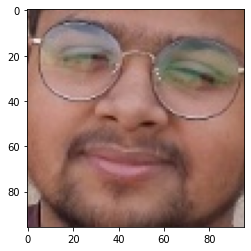

In [ ]:
# Positive Samples
plt.imshow(X[0][0])

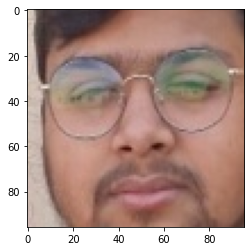

In [ ]:
plt.imshow(X[0][1])


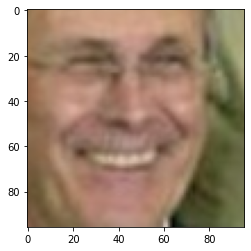

In [ ]:
# Negative Samples
plt.imshow(X[1][0])

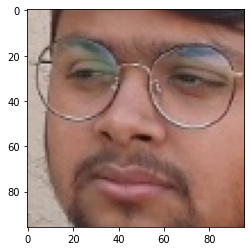

In [ ]:
plt.imshow(X[1][1])

In [ ]:
tf.config.run_functions_eagerly(True)

@tf.function
def train_step(imgs_batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        batch = imgs_batch[:2]
        X = batch[0], batch[1]
        # Get label
        y = imgs_batch[-1]
        
        # Forward pass
        yhat = a_net(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)        
    # Calculate gradients
    grad = tape.gradient(loss, a_net.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, a_net.trainable_variables))
    
    # Return loss
    return loss

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        losses = []
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            loss = np.array(loss)
            losses.append(loss)
            progbar.update(idx+1)
        
        mean_loss = sum(losses)/len(losses)
        print("Loss: {}".format(mean_loss))
        # Save checkpoints
        if epoch % 5 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 25

train(train_data, EPOCHS)


 Epoch 1/25
132/132 [==============================] - 299s 2s/step
Loss: 0.5172228818815766

 Epoch 2/25
132/132 [==============================] - 296s 2s/step
Loss: 0.31535268241934705

 Epoch 3/25
132/132 [==============================] - 279s 2s/step
Loss: 0.2516327558480429

 Epoch 4/25
132/132 [==============================] - 277s 2s/step
Loss: 0.21972944378627068

 Epoch 5/25
132/132 [==============================] - 268s 2s/step
Loss: 0.16980160127930116

 Epoch 6/25
132/132 [==============================] - 258s 2s/step
Loss: 0.19273267207300346

 Epoch 7/25
132/132 [==============================] - 249s 2s/step
Loss: 0.1588371053980099

 Epoch 8/25
132/132 [==============================] - 255s 2s/step
Loss: 0.16067955529345482

 Epoch 9/25
132/132 [==============================] - 250s 2s/step
Loss: 0.15031900882692725

 Epoch 10/25
132/132 [==============================] - 243s 2s/step
Loss: 0.14864802002116587

 Epoch 11/25
132/132 [=============================

#Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
batch = test_data.as_numpy_iterator().next()

In [ ]:
pos, negs, targets = batch

In [ ]:
y_hat = a_net.predict([pos, negs])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
y_hat

array([[1.3404589e-06],
       [9.7940606e-01],
       [2.1457809e-06],
       [9.5934713e-01],
       [9.9930143e-01],
       [8.5053649e-08],
       [8.5226560e-01],
       [3.1950076e-05],
       [3.8888929e-06],
       [6.7587732e-04],
       [9.5983046e-01],
       [9.9992287e-01],
       [9.8668307e-01],
       [4.5313623e-06],
       [9.7161996e-01],
       [8.7471277e-01]], dtype=float32)

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]

In [ ]:
y_true = targets.reshape((1, -1))[0]

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

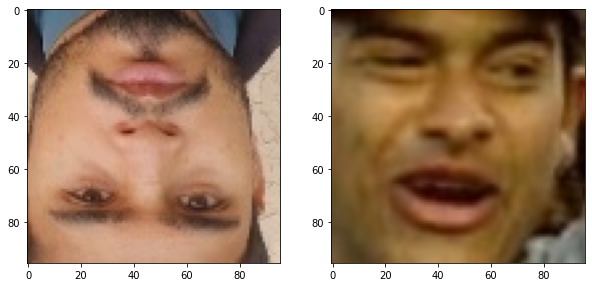

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(pos[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(negs[0])

# Renders cleanly
plt.show()

In [ ]:
y_true[0] # 100% Accurate Model

0

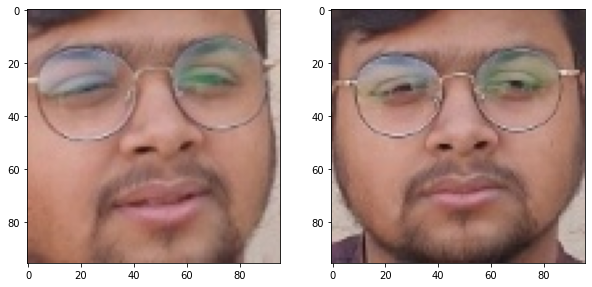

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(pos[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(negs[1])

# Renders cleanly
plt.show()

In [ ]:
y_true[1]

1

In [ ]:
# Save weights
a_net.save('a_net.h5')

In [ ]:
# Reload model 
model = tf.keras.models.load_model('a_net.h5', 
                                   custom_objects={'L1Distance':L1Distance, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
model.summary()

Model: "A_NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 validation_image (InputLayer)  [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 embedding (Functional)         (None, 4096)         27426112    ['input_image[0][0]',            
                                                                  'validation_image[0][0]']       
                                                                                                  
 l1_distance_1 (L1Distance)     (None, 4096)         0           ['embedding[0][0]',          

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("a_net.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqrqsbljl/assets


109727704

In [ ]:
# Using TFLIte without OPTIMIZE
interpreter = tf.lite.Interpreter(model_path="a_net.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_validation_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 96, 96,  3], dtype=int32),
  'shape_signature': array([-1, 96, 96,  3], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 1,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 96, 96,  3], dtype=int32),
  'shape_signature': array([-1, 96, 96,  3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 38,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
np.expand_dims(pos[1], axis=0).shape

(1, 96, 96, 3)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(pos[0], axis=0))
interpreter.set_tensor(input_details[1]['index'], np.expand_dims(negs[0], axis=0))
interpreter.invoke()
pred = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
pred

array([[1.3404475e-06]], dtype=float32)

Implemented By Muhammad Hanan Asghar